In [1]:
import anndata as ad
import numpy as np
import scanpy as sc 

from core.preprocessor import Preprocessor
from core.normalizer import Normalizer
from core.differentiator import Differentiator
from plotmodules.norm_plots import *

CT_COUNTS_META_PATH = 'ct_counts_public_meta.h5ad'

ct_counts_metadata = ad.read_h5ad(CT_COUNTS_META_PATH)


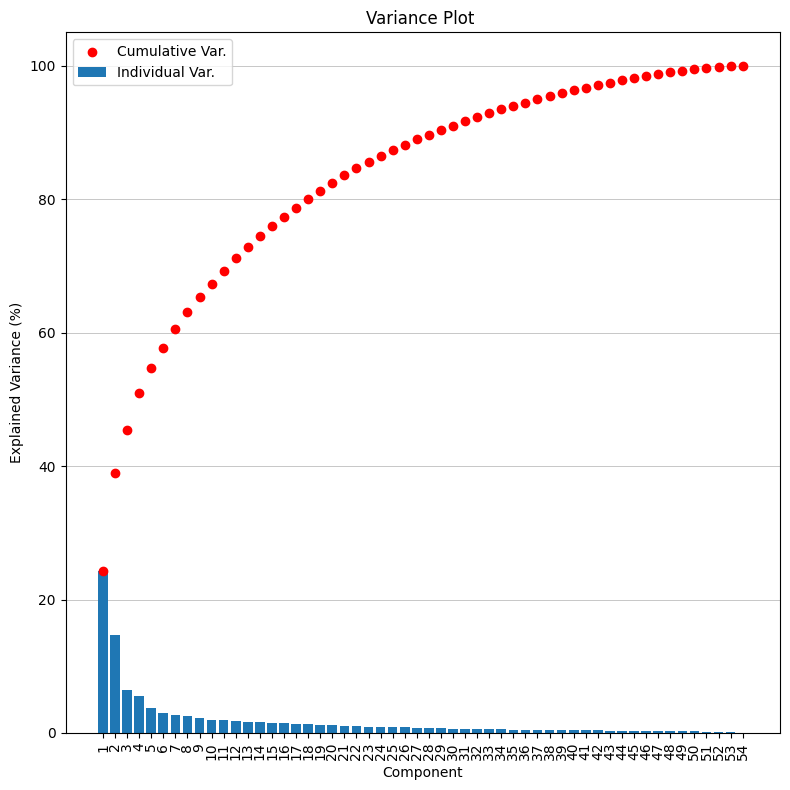

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/preprocessor.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/preprocessor.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


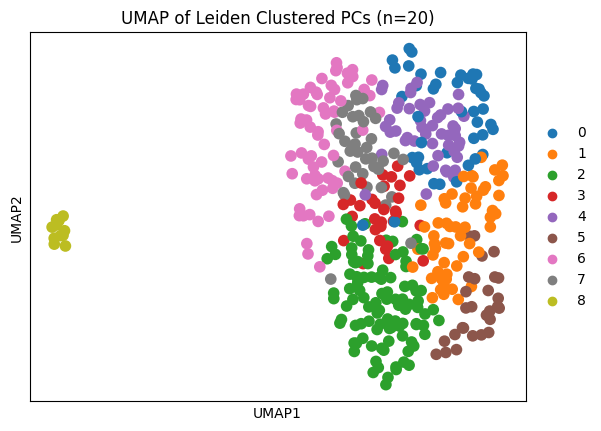

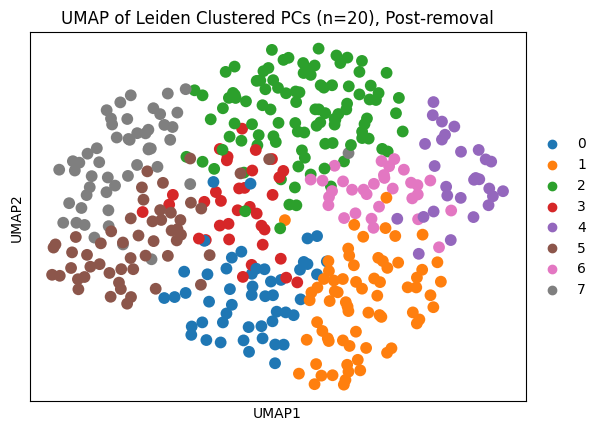

In [2]:
pp = Preprocessor('umap')
pp.show_pca(ct_counts_metadata)
pp.set_n_components(20)
pp.analyze_umap(ct_counts_metadata)
ct_counts_metadata = pp.remove_cluster(ct_counts_metadata, '8')

In [3]:
# Regress out post mortem interval
pp.regress_out(ct_counts_metadata, 'pmi')

/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
# Filter by braak stage and cogdx
ct_counts_metadata = ct_counts_metadata[(ct_counts_metadata.obs['cogdx'].isin([4, 5]) & ct_counts_metadata.obs['braaksc'].isin([5, 6])) | 
                                        (ct_counts_metadata.obs['cogdx'].isin([1]) & ct_counts_metadata.obs['braaksc'].isin([0, 1, 2]))]
pp.categorize(ct_counts_metadata, 'cogdx', pp.COGDX_MAP)
ct_counts_metadata.obs['cogdx_catcode'] = ct_counts_metadata.obs['cogdx_cat'].cat.codes
ct_counts_metadata.obs.value_counts(['braaksc', 'cogdx_cat'])

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/preprocessor.py:84: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f'{column}_cat'] = adata.obs.apply(lambda row: map[row[column]], axis=1).astype('category')


braaksc  cogdx_cat
5.0      AD           70
2.0      H            31
1.0      H            24
6.0      AD            9
0.0      H             6
Name: count, dtype: int64

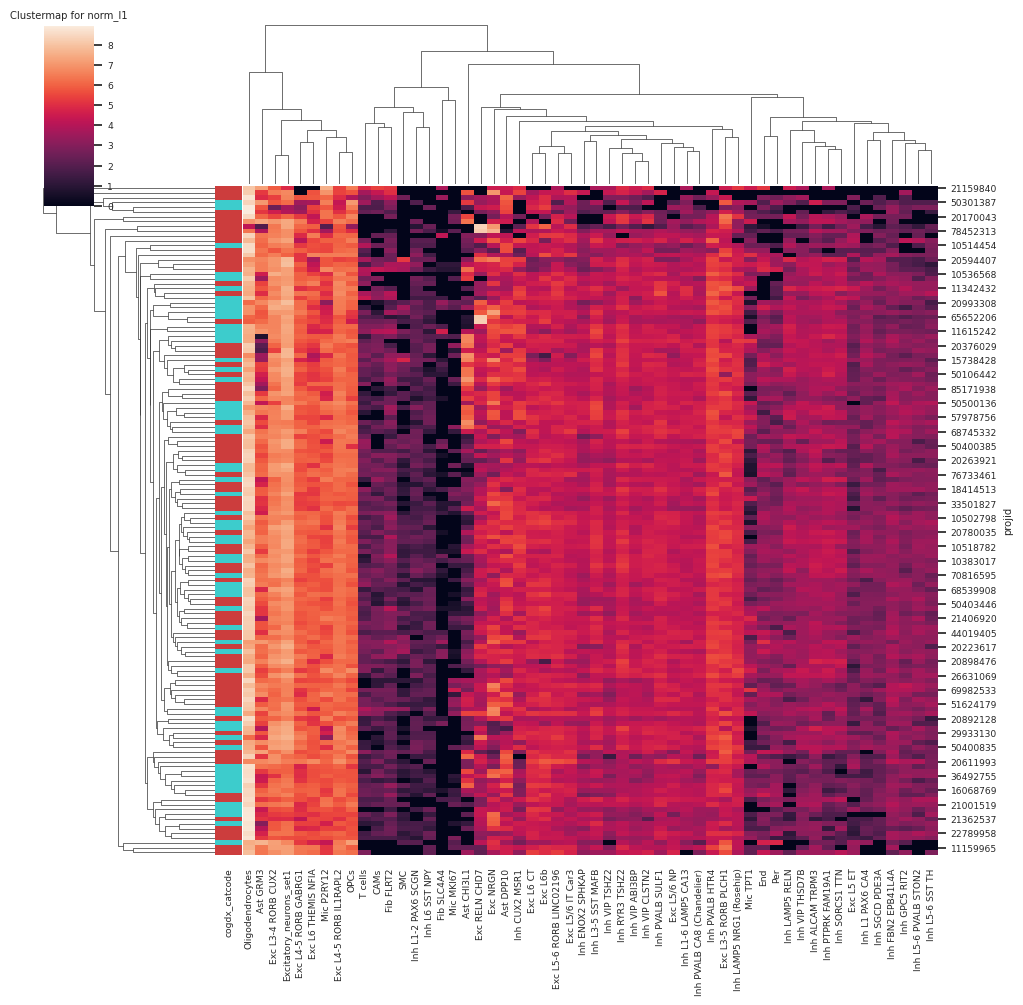

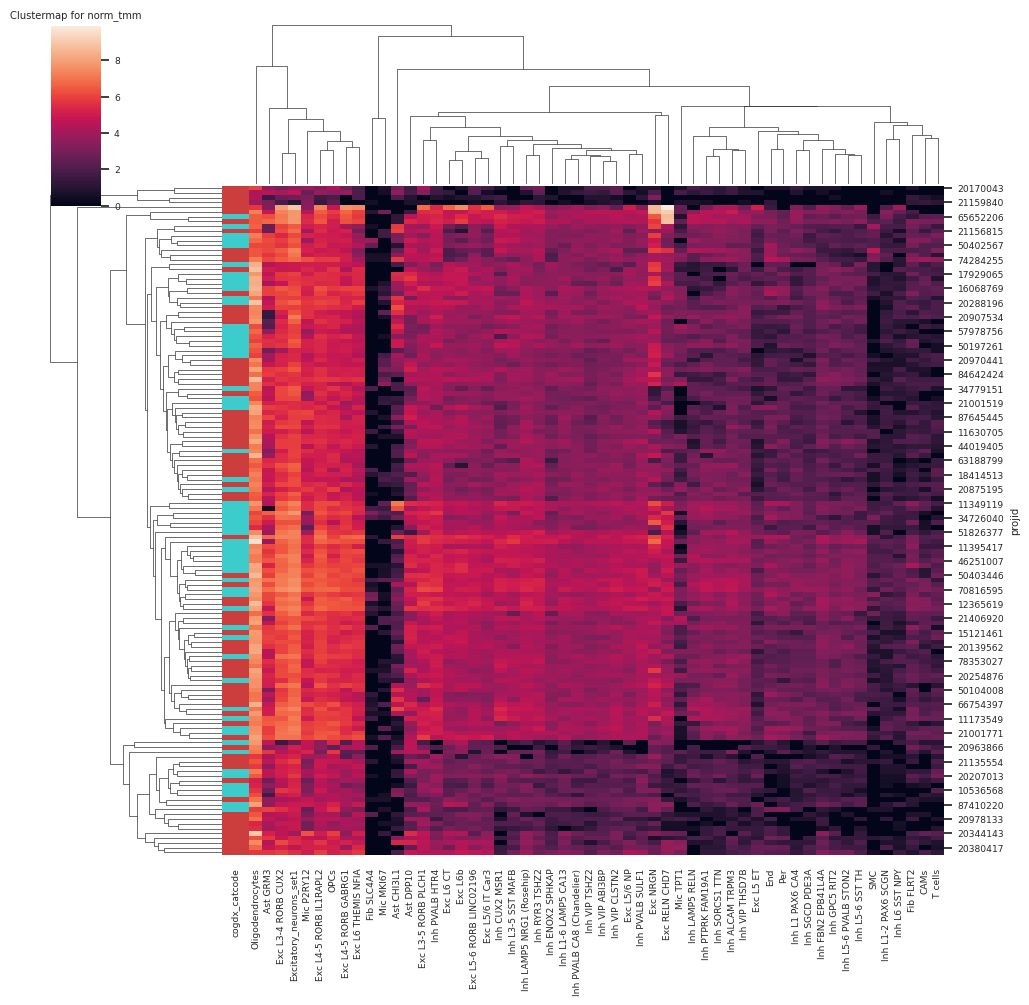

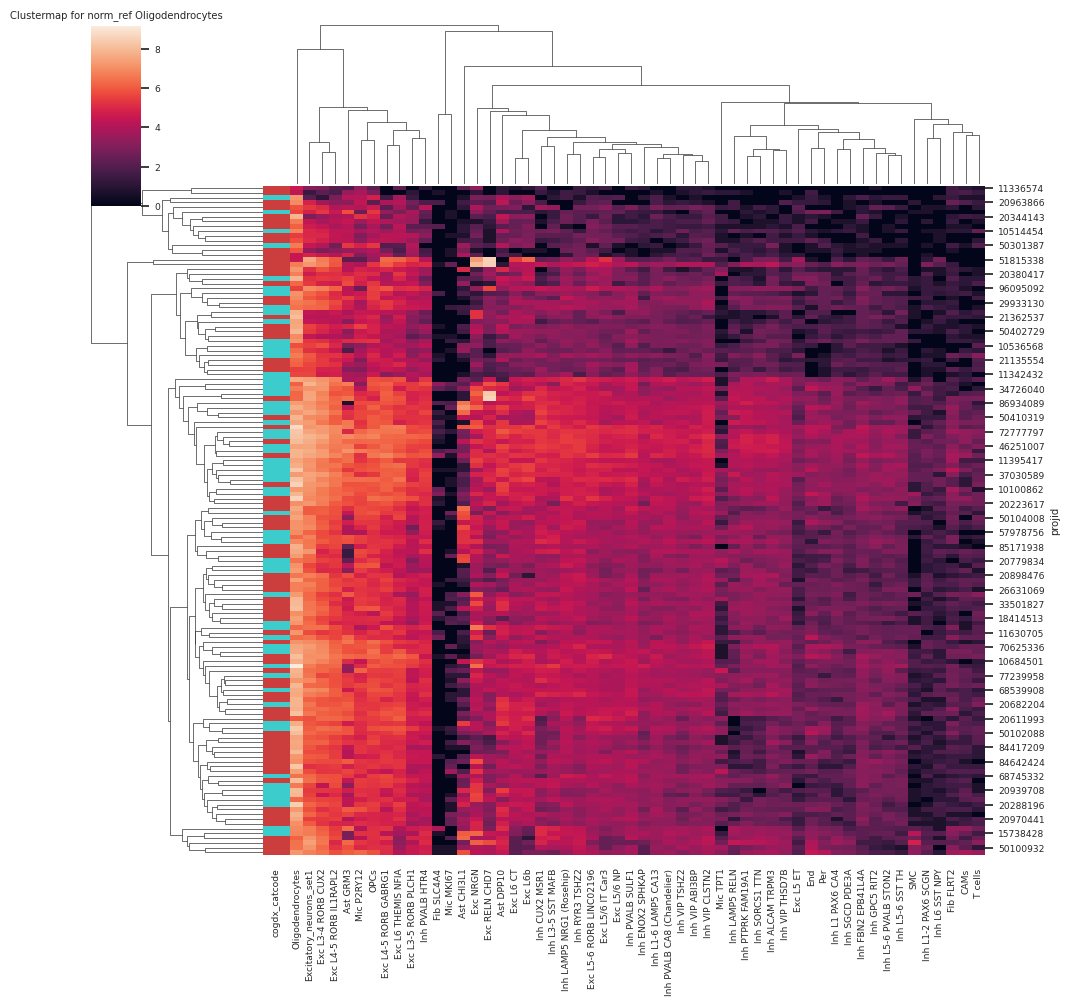

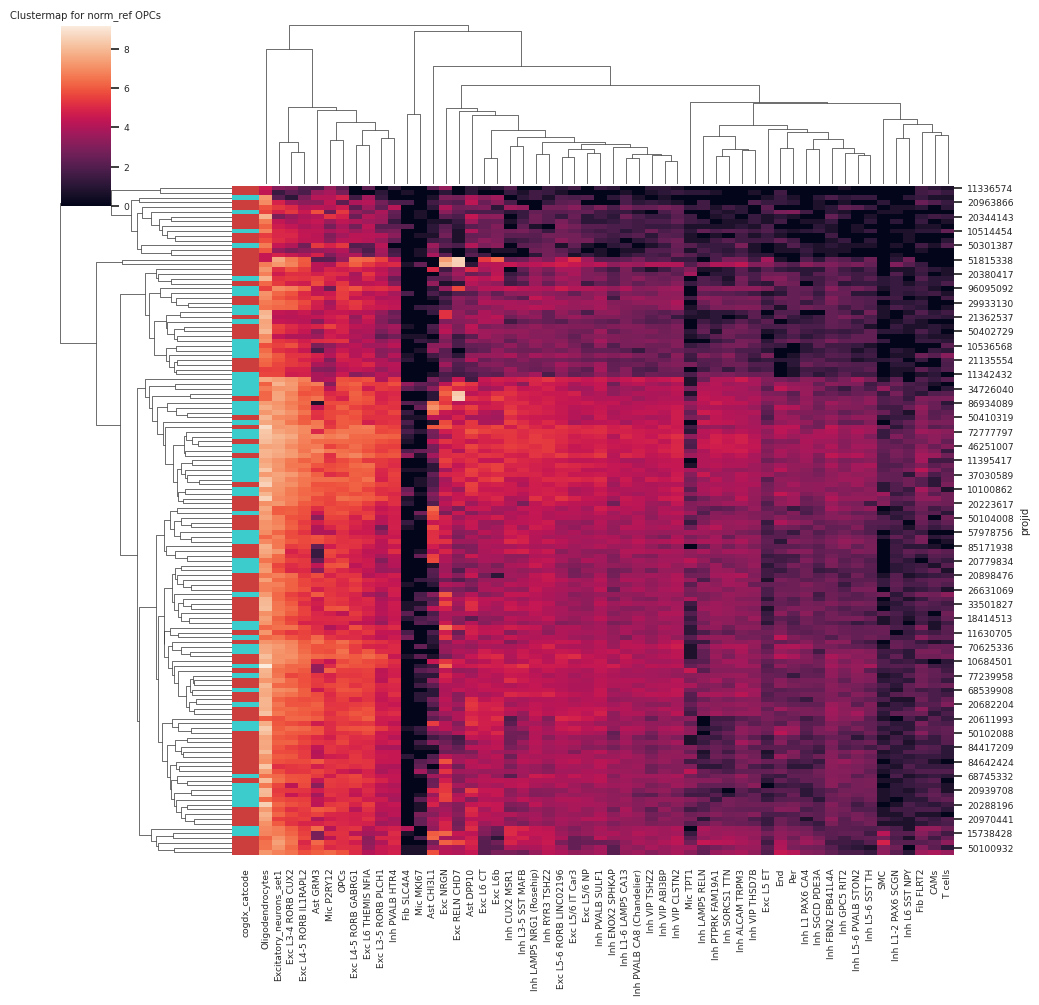

In [5]:
# Normalize the data
normalizer = Normalizer(['l1', 'tmm', 'ref Oligodendrocytes', 'ref OPCs'], np.log1p)
normalizer.normalize_all(ct_counts_metadata)

for layer in normalizer.layer_names:
    generate_clustermap(ct_counts_metadata, layer, 'cogdx_catcode')

In [6]:
# Differential abundance
from scipy.stats import ranksums
from statsmodels.stats.multitest import fdrcorrection

diff = Differentiator(['l1'], ranksums, fdrcorrection, 'cogdx_cat', ('AD', 'H'))
diff.differentiate(ct_counts_metadata)
ct_counts_metadata.var.sort_values('corr_pvalue')

,significant,corr_pvalue
Inh L3-5 SST MAFB,True,0.013940
Inh ENOX2 SPHKAP,True,0.042517
Inh CUX2 MSR1,True,0.042517
Inh VIP TSHZ2,False,0.068789
Inh LAMP5 RELN,False,0.069385
Inh L1 PAX6 CA4,False,0.187705
Inh PTPRK FAM19A1,False,0.187705
Inh SORCS1 TTN,False,0.187705
Oligodendrocytes,False,0.228526
Inh ALCAM TRPM3,False,0.284501


log2( fold change ) = log2( AD/H )


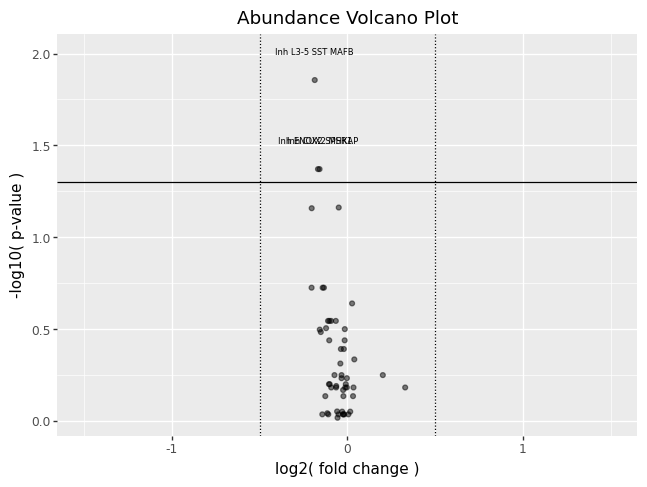

In [7]:
diff.volcano_plot(ct_counts_metadata)

In [9]:
diff.abundance_df.sort_values('corr_pvalue')

,significant,corr_pvalue,log2fc,log10p
Inh L3-5 SST MAFB,True,0.013940,-0.185607,1.855725
Inh ENOX2 SPHKAP,True,0.042517,-0.167230,1.371435
Inh CUX2 MSR1,True,0.042517,-0.158160,1.371435
Inh VIP TSHZ2,False,0.068789,-0.049057,1.162479
Inh LAMP5 RELN,False,0.069385,-0.202961,1.158736
Inh L1 PAX6 CA4,False,0.187705,-0.203583,0.726525
Inh PTPRK FAM19A1,False,0.187705,-0.140661,0.726525
Inh SORCS1 TTN,False,0.187705,-0.133392,0.726525
Oligodendrocytes,False,0.228526,0.026958,0.641064
Inh ALCAM TRPM3,False,0.284501,-0.102542,0.545916
